In [148]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split

Pour être sûr d'utiliser Tensorflow 2.0 :

In [149]:
assert hasattr(tf, "function")

Cette fonction ouvre un fichier C_maps.txt en lecture et récupère les 22 coefficients et les retourne sous forme d'une matrice

In [150]:
def get_data(file_path):
    
    file = open(file_path, "r")

    allText = file.read()

    words = list(map(str, allText.split()))

    matrice_height = int(len(words) / 30)
    matrice = np.ones((matrice_height, 24))

    emplacement = 20
    iter1 = 0
    for i in range(emplacement, int(len(words) / 30) + emplacement):
        iter2 = 0
        for j in range(emplacement + 6, emplacement + 30):
            matrice[(iter1, iter2)] = words[j]
            iter2 += 1
        iter1 += 1
        emplacement += 30
    X_2 = np.delete(matrice, 1, 1)
    X_final = np.delete(X_2, 10, 1)
    
    file.close()
    
    return X_final

Cette fonction ouvre un fichier ctf en lecture et récupère les 3 coefficients d'Euler pour les retourner sous forme de matrice (x, 3)

In [151]:
def read_ctf(file_path):
    
    file2 = open(file_path, "r")
    
    allText2 = file2.read()
    words2 = list(map(str, allText2.split()))
    
    nb_debut_donnees = 88
    nb_mots = len(words2) - nb_debut_donnees
    nb_mots_par_ligne = 11
    
    nb_ligne_matrice = int(nb_mots / nb_mots_par_ligne)
    print("nb_ligne_matrice = " + str(nb_ligne_matrice))
    nb_colonne_matrice = 3
    matrice = np.empty((nb_ligne_matrice, nb_colonne_matrice))
    emplacement = 0
    
    print("Extraction des données à partir du fichier ....")
    for i in range(nb_debut_donnees, nb_mots + nb_debut_donnees, nb_mots_par_ligne):
        matrice[(emplacement, 0)] = words2[i + 5]
        matrice[(emplacement, 1)] = words2[i + 6]
        matrice[(emplacement, 2)] = words2[i + 7]
        emplacement += 1
    print("ok !")    
    file2.close()
    
    return matrice

Cette fonction fait faire des prédiction au modèle et renvoie le score, mae, rmse, r2

In [152]:
def run_experiment(model):
    y_pred = model.predict(X_test)
    print("R^2 : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))

cette fonction renvoie le nombre d'erreur de 1 degré ou plus de la prédiction par rapport aux valeurs réelles
et renvoie les valeurs X d'entrée et y de sortie pour lesquels le modèle prédit mal, sous forme de matrices erreur_x, erreur_y

In [153]:
def pourcentage_erreur(y_pred, y_test, x_test):
   
    err = 0
    marge_derreur = 1 # 1 degre
    erreur_y = np.empty((1, 3), dtype=float)
    erreur_x = np.empty((1, 22), dtype=float)
   
    for i in range(y_pred.shape[0]):
       
        for j in range(y_pred.shape[1]):
           
            error = abs(y_pred[i][j] - y_test[i][j])
            if error >= marge_derreur:
               
                # print(error)
                err += 1
               
                erreur_y = np.append(erreur_y, [y_test[i]], axis=0)
                erreur_x = np.append(erreur_x, [x_test[i]], axis=0)
               
                break
               
    erreur_y = np.delete(erreur_y, 0, axis=0)
    erreur_x = np.delete(erreur_x, 0, axis=0)
    
    for y in erreur_y:
        for i in range(len(y)):
            y[i] = round(y[i], 3)
    for x in erreur_x:
        for j in range(len(x)):
            x[j] = round(x[j], 3)
    
    message = "le pourcentage d'erreur est de "+str((err / y_pred.shape[0]) * 100)+", "+str(err)+" / "+str(y_pred.shape[0])
    return message, erreur_y, erreur_x, err

In [154]:
def calculate_error(y_pred, y_test, x_test):
   
    err = 0
    marge_derreur = 1 # 1 degre
   
    for i in range(y_pred.shape[0]):
       
        for j in range(y_pred.shape[1]):
           
            error = abs(y_pred[i][j] - y_test[i][j])
            
            if error >= marge_derreur:
                
                err += 1
                break
    
    message = "le pourcentage d'erreur est de "+str((err / y_pred.shape[0]) * 100)+", "+str(err)+" / "+str(y_pred.shape[0])
    return message

X matrice d'entrée de dimension (250000, 22)

In [155]:
file_in_path = "datas/C_maps_3.txt"
X = get_data(file_in_path)

Y matrice de dimension (250000, 3) correspondant aux valeurs de sortie q'on attend

In [156]:
file_out_path = "datas/exercise3.ctf"
y = read_ctf(file_out_path)

nb_ligne_matrice = 250000
Extraction des données à partir du fichier ....
ok !


Nous divisons notre jeu de données en jeu d'entraînement, X_train, y_train et en jeu de test, X_test, y_test
le pourcentage de données de test est précisé avec le paramètre test_size, ici de 20%. random_state permet d'avoir le même mélange de données pour pouvoir comparer des modèles entre eux

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [158]:
y_train

array([[255.345,  55.944,  46.056],
       [ 18.18 ,  55.417,  44.979],
       [113.271,  56.696,  48.033],
       ...,
       [201.353,  56.417,  44.685],
       [ 46.988,  57.272,  41.112],
       [155.91 ,  56.922,  46.054]])

In [159]:
for x in X_train:
    for i in range(X_train.shape[1]):
        x[i] = round(x[i], 3)

for y in X_test:
    for j in range(X_test.shape[1]):
        y[j] = round(y[j], 3)

In [160]:
print('Avant normalisation x_train : Minimum = '+str(X_train.min())+', Maximum = '+str(X_train.max()))
print('Avant normalisation x_test : Minimum = '+str(X_test.min())+', Maximum = '+str(X_test.max()))

X_max = (X_train.max())
X_train  = X_train / X_max
X_test = X_test / X_max

print('Après normalisation x_train : Minimum = '+str(X_train.min())+', Maximum = '+str(X_train.max()))
print('Après normalisation x_test : Minimum = '+str(X_test.min())+', Maximum = '+str(X_test.max()))

Avant normalisation x_train : Minimum = -8.145, Maximum = 5.469
Avant normalisation x_test : Minimum = -8.145, Maximum = 5.468
Après normalisation x_train : Minimum = -1.489303346132748, Maximum = 1.0
Après normalisation x_test : Minimum = -1.489303346132748, Maximum = 0.9998171512159444


Importer un modèle qu'on a sauvegardé auparavant dans un fichier h5

Ou on définit notre modèle, entrée de de taille 22 avec quatres couches intermédiaire composés de 256, 128, 64 et 32 neurones avec fonction d'activation Relu et dernière couche, de sortie, de taille 3

In [161]:
model = keras.Sequential()

model.add(Input(shape=(22,)))

model.add(layers.Dense(256, activation="relu")),

model.add(layers.Dense(128, activation="relu")),

model.add(layers.Dense(64, activation="relu")),

model.add(layers.Dense(3))

On définit notre optimiseur et la vitesse d'apprentissage

on précise à notre modèle notre fonction de perte mae, mean absolute error, l'optimiseur et le métrique

In [162]:
model.compile(
    optimizer='adam',
    loss="mae",
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

On entraîne le modèle en précisant nos données d'entraînement, X_train et y_train, le batch_size qui est le nombre de fois qu'on montre nos données au modèle avant qu'il ajuste ses paramètres, le nombre d'epochs qui est le nombre d'entraînement et nos données de valisation, X_test et y_test

In [163]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=50, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('model_dl.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [164]:
history = model.fit(
    x=X_train, 
    y=y_train,
    batch_size=32,
    epochs=1000,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

Epoch 1/1000
6184/6250 [============================>.] - ETA: 0s - loss: 13.9921 - mean_absolute_error: 13.9921
Epoch 00001: val_loss improved from inf to 6.96989, saving model to model_dl.h5
6250/6250 [==============================] - 5s 741us/step - loss: 13.9198 - mean_absolute_error: 13.9198 - val_loss: 6.9699 - val_mean_absolute_error: 6.9699
Epoch 2/1000
6239/6250 [============================>.] - ETA: 0s - loss: 4.4119 - mean_absolute_error: 4.4119
Epoch 00002: val_loss improved from 6.96989 to 3.54734, saving model to model_dl.h5
6250/6250 [==============================] - 4s 649us/step - loss: 4.4094 - mean_absolute_error: 4.4094 - val_loss: 3.5473 - val_mean_absolute_error: 3.5473
Epoch 3/1000
6167/6250 [============================>.] - ETA: 0s - loss: 2.9005 - mean_absolute_error: 2.9005
Epoch 00003: val_loss improved from 3.54734 to 2.53787, saving model to model_dl.h5
6250/6250 [==============================] - 4s 645us/step - loss: 2.8979 - mean_absolute_error: 2.89

Epoch 26/1000
6218/6250 [============================>.] - ETA: 0s - loss: 1.3608 - mean_absolute_error: 1.3608
Epoch 00026: val_loss did not improve from 1.06968
6250/6250 [==============================] - 5s 750us/step - loss: 1.3600 - mean_absolute_error: 1.3600 - val_loss: 1.3466 - val_mean_absolute_error: 1.3466
Epoch 27/1000
6189/6250 [============================>.] - ETA: 0s - loss: 1.2912 - mean_absolute_error: 1.2912
Epoch 00027: val_loss did not improve from 1.06968
6250/6250 [==============================] - 4s 694us/step - loss: 1.2915 - mean_absolute_error: 1.2915 - val_loss: 1.2033 - val_mean_absolute_error: 1.2033
Epoch 28/1000
6247/6250 [============================>.] - ETA: 0s - loss: 1.2832 - mean_absolute_error: 1.2832
Epoch 00028: val_loss did not improve from 1.06968
6250/6250 [==============================] - 8s 1ms/step - loss: 1.2831 - mean_absolute_error: 1.2831 - val_loss: 1.4622 - val_mean_absolute_error: 1.4622
Epoch 29/1000
6250/6250 [=================

6245/6250 [============================>.] - ETA: 0s - loss: 0.3547 - mean_absolute_error: 0.3547  ETA - ETA: 7s - loss: 0.3572 - mean_absolut - ETA: 6s - loss: 0.3588 - mean_absolute_error: 0 - ETA: 6s - loss: 0.3594 -  - ETA: 5s - loss: 0.3578 - mean_absolute_error:  - ETA: 5s - loss: 0.3576 - mean_absolute_error:  
Epoch 00049: val_loss improved from 0.38912 to 0.38491, saving model to model_dl.h5
6250/6250 [==============================] - 37s 6ms/step - loss: 0.3552 - mean_absolute_error: 0.3552 - val_loss: 0.3849 - val_mean_absolute_error: 0.3849
Epoch 50/1000
6241/6250 [============================>.] - ETA: 0s - loss: 0.3543 - mean_absolute_error: 0.3543- ETA: 1s - loss: 0.3574 - mea
Epoch 00050: val_loss did not improve from 0.38491
6250/6250 [==============================] - 32s 5ms/step - loss: 0.3543 - mean_absolute_error: 0.3543 - val_loss: 0.4102 - val_mean_absolute_error: 0.4102
Epoch 51/1000
6250/6250 [==============================] - ETA: 0s - loss: 0.3507 - mean_ab

Epoch 73/1000
6178/6250 [============================>.] - ETA: 0s - loss: 0.3164 - mean_absolute_error: 0.3164
Epoch 00073: val_loss did not improve from 0.33501
6250/6250 [==============================] - 4s 697us/step - loss: 0.3157 - mean_absolute_error: 0.3157 - val_loss: 0.3773 - val_mean_absolute_error: 0.3773
Epoch 74/1000
6249/6250 [============================>.] - ETA: 0s - loss: 0.3111 - mean_absolute_error: 0.3111
Epoch 00074: val_loss did not improve from 0.33501
6250/6250 [==============================] - 4s 697us/step - loss: 0.3111 - mean_absolute_error: 0.3111 - val_loss: 0.4309 - val_mean_absolute_error: 0.4309
Epoch 75/1000
6202/6250 [============================>.] - ETA: 0s - loss: 0.3116 - mean_absolute_error: 0.3116
Epoch 00075: val_loss did not improve from 0.33501
6250/6250 [==============================] - 5s 752us/step - loss: 0.3123 - mean_absolute_error: 0.3123 - val_loss: 0.3755 - val_mean_absolute_error: 0.3755
Epoch 76/1000
6212/6250 [===============

Epoch 98/1000
6173/6250 [============================>.] - ETA: 0s - loss: 0.2294 - mean_absolute_error: 0.2294
Epoch 00098: val_loss did not improve from 0.28257
6250/6250 [==============================] - 4s 686us/step - loss: 0.2297 - mean_absolute_error: 0.2297 - val_loss: 0.2845 - val_mean_absolute_error: 0.2845
Epoch 99/1000
6168/6250 [============================>.] - ETA: 0s - loss: 0.2290 - mean_absolute_error: 0.2290
Epoch 00099: val_loss improved from 0.28257 to 0.27940, saving model to model_dl.h5
6250/6250 [==============================] - 4s 692us/step - loss: 0.2292 - mean_absolute_error: 0.2292 - val_loss: 0.2794 - val_mean_absolute_error: 0.2794
Epoch 100/1000
6235/6250 [============================>.] - ETA: 0s - loss: 0.2288 - mean_absolute_error: 0.2288
Epoch 00100: val_loss did not improve from 0.27940
6250/6250 [==============================] - 5s 737us/step - loss: 0.2289 - mean_absolute_error: 0.2289 - val_loss: 0.2859 - val_mean_absolute_error: 0.2859
Epoch 

6238/6250 [============================>.] - ETA: 0s - loss: 0.2254 - mean_absolute_error: 0.2254
Epoch 00123: val_loss did not improve from 0.27760
6250/6250 [==============================] - 4s 680us/step - loss: 0.2254 - mean_absolute_error: 0.2254 - val_loss: 0.2821 - val_mean_absolute_error: 0.2821
Epoch 124/1000
6227/6250 [============================>.] - ETA: 0s - loss: 0.2247 - mean_absolute_error: 0.2247
Epoch 00124: val_loss did not improve from 0.27760
6250/6250 [==============================] - 4s 680us/step - loss: 0.2245 - mean_absolute_error: 0.2245 - val_loss: 0.2790 - val_mean_absolute_error: 0.2790
Epoch 125/1000
6206/6250 [============================>.] - ETA: 0s - loss: 0.2245 - mean_absolute_error: 0.2245
Epoch 00125: val_loss improved from 0.27760 to 0.27715, saving model to model_dl.h5
6250/6250 [==============================] - 4s 690us/step - loss: 0.2244 - mean_absolute_error: 0.2244 - val_loss: 0.2772 - val_mean_absolute_error: 0.2772
Epoch 126/1000
6248

6247/6250 [============================>.] - ETA: 0s - loss: 0.2221 - mean_absolute_error: 0.2221
Epoch 00148: val_loss did not improve from 0.27383
6250/6250 [==============================] - 5s 734us/step - loss: 0.2221 - mean_absolute_error: 0.2221 - val_loss: 0.2805 - val_mean_absolute_error: 0.2805
Epoch 149/1000
6246/6250 [============================>.] - ETA: 0s - loss: 0.2203 - mean_absolute_error: 0.2203
Epoch 00149: val_loss did not improve from 0.27383
6250/6250 [==============================] - 4s 678us/step - loss: 0.2204 - mean_absolute_error: 0.2204 - val_loss: 0.2819 - val_mean_absolute_error: 0.2819
Epoch 150/1000
6249/6250 [============================>.] - ETA: 0s - loss: 0.2220 - mean_absolute_error: 0.2220
Epoch 00150: val_loss did not improve from 0.27383
6250/6250 [==============================] - 4s 681us/step - loss: 0.2220 - mean_absolute_error: 0.2220 - val_loss: 0.2764 - val_mean_absolute_error: 0.2764
Epoch 151/1000
6197/6250 [==========================

6244/6250 [============================>.] - ETA: 0s - loss: 0.2180 - mean_absolute_error: 0.2180
Epoch 00173: val_loss did not improve from 0.27140
6250/6250 [==============================] - 4s 700us/step - loss: 0.2186 - mean_absolute_error: 0.2186 - val_loss: 0.2738 - val_mean_absolute_error: 0.2738
Epoch 174/1000
6239/6250 [============================>.] - ETA: 0s - loss: 0.2183 - mean_absolute_error: 0.2183
Epoch 00174: val_loss did not improve from 0.27140
6250/6250 [==============================] - 4s 699us/step - loss: 0.2182 - mean_absolute_error: 0.2182 - val_loss: 0.2761 - val_mean_absolute_error: 0.2761
Epoch 175/1000
6202/6250 [============================>.] - ETA: 0s - loss: 0.2165 - mean_absolute_error: 0.2165
Epoch 00175: val_loss did not improve from 0.27140
6250/6250 [==============================] - 4s 682us/step - loss: 0.2173 - mean_absolute_error: 0.2173 - val_loss: 0.2743 - val_mean_absolute_error: 0.2743
Epoch 176/1000
6232/6250 [==========================

6205/6250 [============================>.] - ETA: 0s - loss: 0.2156 - mean_absolute_error: 0.2156
Epoch 00198: val_loss did not improve from 0.26607
6250/6250 [==============================] - 4s 684us/step - loss: 0.2151 - mean_absolute_error: 0.2151 - val_loss: 0.2710 - val_mean_absolute_error: 0.2710
Epoch 199/1000
6217/6250 [============================>.] - ETA: 0s - loss: 0.2151 - mean_absolute_error: 0.2151
Epoch 00199: val_loss did not improve from 0.26607
6250/6250 [==============================] - 5s 722us/step - loss: 0.2146 - mean_absolute_error: 0.2146 - val_loss: 0.2685 - val_mean_absolute_error: 0.2685
Epoch 200/1000
6238/6250 [============================>.] - ETA: 0s - loss: 0.2137 - mean_absolute_error: 0.2137
Epoch 00200: val_loss did not improve from 0.26607
6250/6250 [==============================] - 4s 679us/step - loss: 0.2137 - mean_absolute_error: 0.2137 - val_loss: 0.2738 - val_mean_absolute_error: 0.2738
Epoch 201/1000
6183/6250 [==========================

6169/6250 [============================>.] - ETA: 0s - loss: 0.2109 - mean_absolute_error: 0.2109
Epoch 00223: val_loss did not improve from 0.26417
6250/6250 [==============================] - 4s 677us/step - loss: 0.2110 - mean_absolute_error: 0.2110 - val_loss: 0.2734 - val_mean_absolute_error: 0.2734
Epoch 224/1000
6209/6250 [============================>.] - ETA: 0s - loss: 0.2119 - mean_absolute_error: 0.2119
Epoch 00224: val_loss did not improve from 0.26417
6250/6250 [==============================] - 4s 684us/step - loss: 0.2116 - mean_absolute_error: 0.2116 - val_loss: 0.2719 - val_mean_absolute_error: 0.2719
Epoch 225/1000
6175/6250 [============================>.] - ETA: 0s - loss: 0.2122 - mean_absolute_error: 0.2122
Epoch 00225: val_loss did not improve from 0.26417
6250/6250 [==============================] - 5s 727us/step - loss: 0.2119 - mean_absolute_error: 0.2119 - val_loss: 0.2660 - val_mean_absolute_error: 0.2660
Epoch 226/1000
6236/6250 [==========================

Epoch 249/1000
6163/6250 [============================>.] - ETA: 0s - loss: 0.2070 - mean_absolute_error: 0.2070
Epoch 00249: val_loss did not improve from 0.26140
6250/6250 [==============================] - 4s 677us/step - loss: 0.2072 - mean_absolute_error: 0.2072 - val_loss: 0.2663 - val_mean_absolute_error: 0.2663
Epoch 250/1000
6246/6250 [============================>.] - ETA: 0s - loss: 0.2072 - mean_absolute_error: 0.2072
Epoch 00250: val_loss improved from 0.26140 to 0.25966, saving model to model_dl.h5
6250/6250 [==============================] - 4s 683us/step - loss: 0.2071 - mean_absolute_error: 0.2071 - val_loss: 0.2597 - val_mean_absolute_error: 0.2597
Epoch 251/1000
6231/6250 [============================>.] - ETA: 0s - loss: 0.2067 - mean_absolute_error: 0.2067
Epoch 00251: val_loss did not improve from 0.25966
6250/6250 [==============================] - 5s 724us/step - loss: 0.2068 - mean_absolute_error: 0.2068 - val_loss: 0.2687 - val_mean_absolute_error: 0.2687
Epoc

6248/6250 [============================>.] - ETA: 0s - loss: 0.2043 - mean_absolute_error: 0.2043
Epoch 00274: val_loss did not improve from 0.25837
6250/6250 [==============================] - 4s 677us/step - loss: 0.2043 - mean_absolute_error: 0.2043 - val_loss: 0.2605 - val_mean_absolute_error: 0.2605
Epoch 275/1000
6178/6250 [============================>.] - ETA: 0s - loss: 0.2046 - mean_absolute_error: 0.2046
Epoch 00275: val_loss did not improve from 0.25837
6250/6250 [==============================] - 4s 703us/step - loss: 0.2045 - mean_absolute_error: 0.2045 - val_loss: 0.2601 - val_mean_absolute_error: 0.2601
Epoch 276/1000
6227/6250 [============================>.] - ETA: 0s - loss: 0.2047 - mean_absolute_error: 0.2047
Epoch 00276: val_loss improved from 0.25837 to 0.25701, saving model to model_dl.h5
6250/6250 [==============================] - 4s 695us/step - loss: 0.2049 - mean_absolute_error: 0.2049 - val_loss: 0.2570 - val_mean_absolute_error: 0.2570
Epoch 277/1000
6226

Epoch 300/1000
6177/6250 [============================>.] - ETA: 0s - loss: 0.2021 - mean_absolute_error: 0.2021
Epoch 00300: val_loss did not improve from 0.25592
6250/6250 [==============================] - 4s 675us/step - loss: 0.2024 - mean_absolute_error: 0.2024 - val_loss: 0.2569 - val_mean_absolute_error: 0.2569
Epoch 301/1000
6241/6250 [============================>.] - ETA: 0s - loss: 0.2024 - mean_absolute_error: 0.2024
Epoch 00301: val_loss did not improve from 0.25592
6250/6250 [==============================] - 4s 680us/step - loss: 0.2022 - mean_absolute_error: 0.2022 - val_loss: 0.2572 - val_mean_absolute_error: 0.2572
Epoch 302/1000
6187/6250 [============================>.] - ETA: 0s - loss: 0.2032 - mean_absolute_error: 0.2032
Epoch 00302: val_loss did not improve from 0.25592
6250/6250 [==============================] - 4s 709us/step - loss: 0.2026 - mean_absolute_error: 0.2026 - val_loss: 0.2592 - val_mean_absolute_error: 0.2592
Epoch 303/1000
6183/6250 [===========

6192/6250 [============================>.] - ETA: 0s - loss: 0.1997 - mean_absolute_error: 0.1997
Epoch 00325: val_loss did not improve from 0.25235
6250/6250 [==============================] - 4s 710us/step - loss: 0.2001 - mean_absolute_error: 0.2001 - val_loss: 0.2577 - val_mean_absolute_error: 0.2577
Epoch 326/1000
6214/6250 [============================>.] - ETA: 0s - loss: 0.2007 - mean_absolute_error: 0.2007
Epoch 00326: val_loss did not improve from 0.25235
6250/6250 [==============================] - 4s 678us/step - loss: 0.2000 - mean_absolute_error: 0.2000 - val_loss: 0.2586 - val_mean_absolute_error: 0.2586
Epoch 327/1000
6230/6250 [============================>.] - ETA: 0s - loss: 0.1984 - mean_absolute_error: 0.1984
Epoch 00327: val_loss did not improve from 0.25235
6250/6250 [==============================] - 4s 682us/step - loss: 0.1984 - mean_absolute_error: 0.1984 - val_loss: 0.2555 - val_mean_absolute_error: 0.2555
Epoch 328/1000
6175/6250 [==========================

6234/6250 [============================>.] - ETA: 0s - loss: 0.1979 - mean_absolute_error: 0.1979
Epoch 00350: val_loss did not improve from 0.24958
6250/6250 [==============================] - 5s 729us/step - loss: 0.1977 - mean_absolute_error: 0.1977 - val_loss: 0.2515 - val_mean_absolute_error: 0.2515
Epoch 351/1000
6229/6250 [============================>.] - ETA: 0s - loss: 0.1972 - mean_absolute_error: 0.1972
Epoch 00351: val_loss did not improve from 0.24958
6250/6250 [==============================] - 4s 686us/step - loss: 0.1973 - mean_absolute_error: 0.1973 - val_loss: 0.2513 - val_mean_absolute_error: 0.2513
Epoch 352/1000
6209/6250 [============================>.] - ETA: 0s - loss: 0.1968 - mean_absolute_error: 0.1968
Epoch 00352: val_loss did not improve from 0.24958
6250/6250 [==============================] - 4s 680us/step - loss: 0.1967 - mean_absolute_error: 0.1967 - val_loss: 0.2521 - val_mean_absolute_error: 0.2521
Epoch 353/1000
6199/6250 [==========================

Epoch 376/1000
6202/6250 [============================>.] - ETA: 0s - loss: 0.1944 - mean_absolute_error: 0.1944
Epoch 00376: val_loss did not improve from 0.24704
6250/6250 [==============================] - 5s 736us/step - loss: 0.1942 - mean_absolute_error: 0.1942 - val_loss: 0.2543 - val_mean_absolute_error: 0.2543
Epoch 377/1000
6208/6250 [============================>.] - ETA: 0s - loss: 0.1939 - mean_absolute_error: 0.1939
Epoch 00377: val_loss did not improve from 0.24704
6250/6250 [==============================] - 4s 682us/step - loss: 0.1940 - mean_absolute_error: 0.1940 - val_loss: 0.2536 - val_mean_absolute_error: 0.2536
Epoch 378/1000
6205/6250 [============================>.] - ETA: 0s - loss: 0.1937 - mean_absolute_error: 0.1937
Epoch 00378: val_loss did not improve from 0.24704
6250/6250 [==============================] - 4s 680us/step - loss: 0.1939 - mean_absolute_error: 0.1939 - val_loss: 0.2473 - val_mean_absolute_error: 0.2473
Epoch 379/1000
6194/6250 [===========

6249/6250 [============================>.] - ETA: 0s - loss: 0.1915 - mean_absolute_error: 0.1915
Epoch 00401: val_loss did not improve from 0.24435
6250/6250 [==============================] - 4s 696us/step - loss: 0.1915 - mean_absolute_error: 0.1915 - val_loss: 0.2536 - val_mean_absolute_error: 0.2536
Epoch 402/1000
6238/6250 [============================>.] - ETA: 0s - loss: 0.1921 - mean_absolute_error: 0.1921
Epoch 00402: val_loss did not improve from 0.24435
6250/6250 [==============================] - 5s 724us/step - loss: 0.1921 - mean_absolute_error: 0.1921 - val_loss: 0.2472 - val_mean_absolute_error: 0.2472
Epoch 403/1000
6184/6250 [============================>.] - ETA: 0s - loss: 0.1905 - mean_absolute_error: 0.1905
Epoch 00403: val_loss did not improve from 0.24435
6250/6250 [==============================] - 4s 680us/step - loss: 0.1907 - mean_absolute_error: 0.1907 - val_loss: 0.2458 - val_mean_absolute_error: 0.2458
Epoch 404/1000
6165/6250 [==========================

Epoch 427/1000
6237/6250 [============================>.] - ETA: 0s - loss: 0.1896 - mean_absolute_error: 0.1896
Epoch 00427: val_loss improved from 0.24378 to 0.24291, saving model to model_dl.h5
6250/6250 [==============================] - 5s 727us/step - loss: 0.1899 - mean_absolute_error: 0.1899 - val_loss: 0.2429 - val_mean_absolute_error: 0.2429
Epoch 428/1000
6192/6250 [============================>.] - ETA: 0s - loss: 0.1893 - mean_absolute_error: 0.1893
Epoch 00428: val_loss did not improve from 0.24291
6250/6250 [==============================] - 4s 694us/step - loss: 0.1889 - mean_absolute_error: 0.1889 - val_loss: 0.2489 - val_mean_absolute_error: 0.2489
Epoch 429/1000
6205/6250 [============================>.] - ETA: 0s - loss: 0.1897 - mean_absolute_error: 0.1897
Epoch 00429: val_loss did not improve from 0.24291
6250/6250 [==============================] - 4s 684us/step - loss: 0.1892 - mean_absolute_error: 0.1892 - val_loss: 0.2451 - val_mean_absolute_error: 0.2451
Epoc

6170/6250 [============================>.] - ETA: 0s - loss: 0.1860 - mean_absolute_error: 0.1860
Epoch 00452: val_loss did not improve from 0.24285
6250/6250 [==============================] - 4s 688us/step - loss: 0.1867 - mean_absolute_error: 0.1867 - val_loss: 0.2465 - val_mean_absolute_error: 0.2465
Epoch 453/1000
6195/6250 [============================>.] - ETA: 0s - loss: 0.1860 - mean_absolute_error: 0.1860
Epoch 00453: val_loss did not improve from 0.24285
6250/6250 [==============================] - 5s 738us/step - loss: 0.1866 - mean_absolute_error: 0.1866 - val_loss: 0.2491 - val_mean_absolute_error: 0.2491
Epoch 454/1000
6183/6250 [============================>.] - ETA: 0s - loss: 0.1859 - mean_absolute_error: 0.1859
Epoch 00454: val_loss did not improve from 0.24285
6250/6250 [==============================] - 4s 683us/step - loss: 0.1861 - mean_absolute_error: 0.1861 - val_loss: 0.2433 - val_mean_absolute_error: 0.2433
Epoch 455/1000
6178/6250 [==========================

Epoch 478/1000
6192/6250 [============================>.] - ETA: 0s - loss: 0.1843 - mean_absolute_error: 0.1843
Epoch 00478: val_loss did not improve from 0.23639
6250/6250 [==============================] - 5s 735us/step - loss: 0.1846 - mean_absolute_error: 0.1846 - val_loss: 0.2387 - val_mean_absolute_error: 0.2387
Epoch 479/1000
6233/6250 [============================>.] - ETA: 0s - loss: 0.1851 - mean_absolute_error: 0.1851
Epoch 00479: val_loss did not improve from 0.23639
6250/6250 [==============================] - 4s 687us/step - loss: 0.1854 - mean_absolute_error: 0.1854 - val_loss: 0.2429 - val_mean_absolute_error: 0.2429
Epoch 480/1000
6244/6250 [============================>.] - ETA: 0s - loss: 0.1850 - mean_absolute_error: 0.1850
Epoch 00480: val_loss did not improve from 0.23639
6250/6250 [==============================] - 4s 689us/step - loss: 0.1849 - mean_absolute_error: 0.1849 - val_loss: 0.2380 - val_mean_absolute_error: 0.2380
Epoch 481/1000
6234/6250 [===========

Epoch 504/1000
6242/6250 [============================>.] - ETA: 0s - loss: 0.1827 - mean_absolute_error: 0.1827
Epoch 00504: val_loss did not improve from 0.23639
6250/6250 [==============================] - 4s 718us/step - loss: 0.1826 - mean_absolute_error: 0.1826 - val_loss: 0.2400 - val_mean_absolute_error: 0.2400
Epoch 505/1000
6238/6250 [============================>.] - ETA: 0s - loss: 0.1816 - mean_absolute_error: 0.1816
Epoch 00505: val_loss did not improve from 0.23639
6250/6250 [==============================] - 5s 829us/step - loss: 0.1820 - mean_absolute_error: 0.1820 - val_loss: 0.2374 - val_mean_absolute_error: 0.2374
Epoch 506/1000
6198/6250 [============================>.] - ETA: 0s - loss: 0.1834 - mean_absolute_error: 0.1834
Epoch 00506: val_loss did not improve from 0.23639
6250/6250 [==============================] - 5s 790us/step - loss: 0.1830 - mean_absolute_error: 0.1830 - val_loss: 0.2409 - val_mean_absolute_error: 0.2409
Epoch 507/1000
6244/6250 [===========

In [67]:
history = model.fit(
    x=X_train, 
    y=y_train, 
    epochs=10000,
    batch_size=1000000,
    validation_data=(X_test, y_test)
)

Epoch 1/10000
1/1 [==============================] - 0s 53ms/step - loss: 0.1514 - mae: 0.1514 - val_loss: 0.2183 - val_mae: 0.2183
Epoch 2/10000
1/1 [==============================] - 0s 52ms/step - loss: 0.1514 - mae: 0.1514 - val_loss: 0.2183 - val_mae: 0.2183
Epoch 3/10000
1/1 [==============================] - 0s 44ms/step - loss: 0.1514 - mae: 0.1514 - val_loss: 0.2183 - val_mae: 0.2183
Epoch 4/10000
1/1 [==============================] - 0s 46ms/step - loss: 0.1514 - mae: 0.1514 - val_loss: 0.2183 - val_mae: 0.2183
Epoch 5/10000
1/1 [==============================] - 0s 52ms/step - loss: 0.1514 - mae: 0.1514 - val_loss: 0.2183 - val_mae: 0.2183
Epoch 6/10000
1/1 [==============================] - 0s 52ms/step - loss: 0.1514 - mae: 0.1514 - val_loss: 0.2183 - val_mae: 0.2183
Epoch 7/10000
1/1 [==============================] - 0s 49ms/step - loss: 0.1514 - mae: 0.1514 - val_loss: 0.2183 - val_mae: 0.2183
Epoch 8/10000
1/1 [==============================] - 0s 46ms/step - loss: 0.

1/1 [==============================] - 0s 51ms/step - loss: 0.1514 - mae: 0.1514 - val_loss: 0.2182 - val_mae: 0.2182
Epoch 63/10000
1/1 [==============================] - 0s 64ms/step - loss: 0.1514 - mae: 0.1514 - val_loss: 0.2182 - val_mae: 0.2182
Epoch 64/10000
1/1 [==============================] - 0s 51ms/step - loss: 0.1514 - mae: 0.1514 - val_loss: 0.2182 - val_mae: 0.2182
Epoch 65/10000
1/1 [==============================] - 0s 52ms/step - loss: 0.1514 - mae: 0.1514 - val_loss: 0.2182 - val_mae: 0.2182
Epoch 66/10000
1/1 [==============================] - 0s 62ms/step - loss: 0.1514 - mae: 0.1514 - val_loss: 0.2182 - val_mae: 0.2182
Epoch 67/10000
1/1 [==============================] - 0s 52ms/step - loss: 0.1514 - mae: 0.1514 - val_loss: 0.2182 - val_mae: 0.2182
Epoch 68/10000


KeyboardInterrupt: 

on demande au modèle de faire des prédictions pour les valeurs de X_test, de dimension (50000, 22).
val_predictions aura une dimension de (50000, 3)

In [68]:
val_predictions = model.predict(X_test)

On affiche les dix premières valeurs de prédictions (val_predictions) et les valeurs réelles attendues (y_test)

In [69]:
print("y_test : \n", y_test[:10])
print("=====================================")
print("y_pred : \n", val_predictions[:10])

y_test : 
 [[238.12   56.771  45.008]
 [312.516  56.229  43.907]
 [  4.188  56.151  45.955]
 [288.417  55.477  44.926]
 [222.128  55.859  43.357]
 [139.528  56.78   49.055]
 [347.173  55.879  43.91 ]
 [  1.74   56.774  48.945]
 [274.916  57.279  47.987]
 [298.611  56.402  43.524]]
y_pred : 
 [[238.05734    56.715553   44.96208  ]
 [312.56778    56.220467   43.893627 ]
 [  4.2060814  56.125698   45.90312  ]
 [288.465      55.465034   44.905205 ]
 [222.24557    55.885387   43.280846 ]
 [139.66562    56.829796   49.102215 ]
 [346.9167     55.85209    43.916355 ]
 [  1.3074304  56.830135   49.065414 ]
 [274.77383    57.298454   48.03428  ]
 [298.5663     56.396877   43.535397 ]]


On calcule l'erreur moyenne absolue en donnant à la fonction les valeurs prédites et réelles

In [70]:
val_mae = mean_absolute_error(val_predictions, y_test)
print("Validation MAE for Model: {}".format(val_mae))

Validation MAE for Model: 0.2182454448306533


In [71]:
val_mse = mean_squared_error(y_test, val_predictions)
print("Validation MSE for Model: {}".format(val_mse))

Validation MSE for Model: 15.997438454209089


In [72]:
y_test.shape

(50000, 3)

On affiche trois graphiques pour chaque valeur d'Euler, en x les valeurs réelles et en y les valeurs prédites

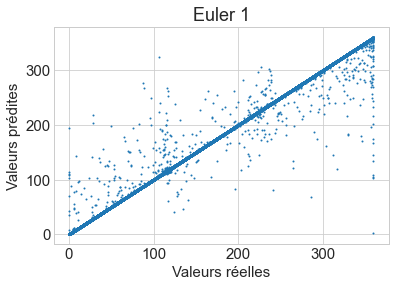

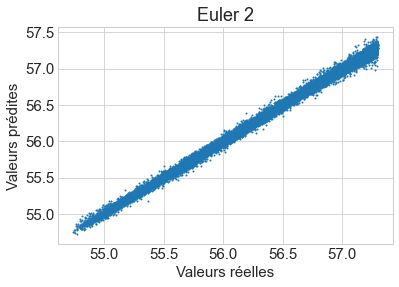

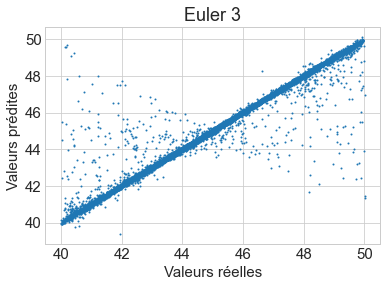

In [73]:
for i in range(3):
    axe = plt.axes()
    plt.rcParams.update({'font.size':15})
    plt.style.use('seaborn-whitegrid')
    plt.scatter(y_test[:, i], val_predictions[:, i], s=1)
    plt.title('Euler ' + str(i+1))
    axe.set(xlabel="Valeurs réelles", ylabel="Valeurs prédites")
    plt.show()

On affiche le nombre d'erreurs de 1 degré ou plus de notre modèle

In [74]:
message = calculate_error(val_predictions, y_test, X_test)
print(message)

le pourcentage d'erreur est de 1.466, 733 / 50000


on mesure la qualité de prédiction de notre modèle avec l'écart quadratique moyen, mae et le coefficient de détermination

In [75]:
run_experiment(model)

R^2 :  0.9922143318808395
MAE : 0.2182454448306533
RMSE: 3.999679793959648


On importe d'autres données que le modèle n'a jamais vu pour le tester

In [76]:
X_2 = get_data("datas/C_maps_2.txt")
y_2 = read_ctf("datas/exercise2.ctf")
X_4 = get_data("datas/C_maps_4.txt")
y_4 = read_ctf("datas/exercise4.ctf")
X_5 = get_data("datas/C_maps_5.txt")
y_5 = read_ctf("datas/exercise5.ctf")

nb_ligne_matrice = 250000
Extraction des données à partir du fichier ....
ok !
nb_ligne_matrice = 250000
Extraction des données à partir du fichier ....
ok !
nb_ligne_matrice = 250000
Extraction des données à partir du fichier ....
ok !


on fait prédire nos nouvelles données et on affiche le mae du modèle sur ces nouvelles données

In [77]:
# X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X_3, y_3, test_size=.2, random_state=1)
val_predictions2 = model.predict(X_2)
val_mae2 = mean_absolute_error(val_predictions3, y_2)
print("Validation MAE for Model: {}".format(val_mae3))

# X_4_train, X_4_test, y_4_train, y_4_test = train_test_split(X_4, y_4, test_size=.2, random_state=1)
val_predictions4 = model.predict(X_4)
val_mae4 = mean_absolute_error(val_predictions4, y_4)
print("Validation MAE for Model: {}".format(val_mae4))

# X_5_train, X_5_test, y_5_train, y_5_test = train_test_split(X_5, y_5, test_size=.2, random_state=1)
val_predictions5 = model.predict(X_5)
val_mae5 = mean_absolute_error(val_predictions5, y_5)
print("Validation MAE for Model: {}".format(val_mae5))

Validation MAE for Model: 0.23478572050942423
Validation MAE for Model: 0.21299297997762312
Validation MAE for Model: 0.21725743676172501


on affiche dans un graphique les valeurs réelles et les valeurs prédites et on observe la courbe

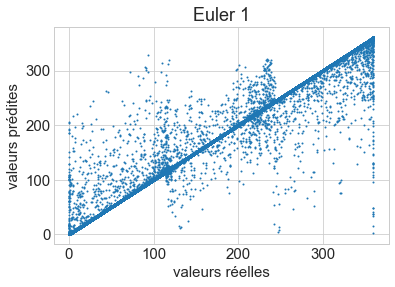

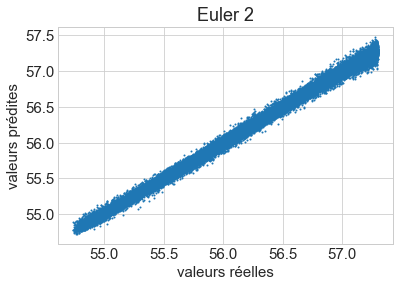

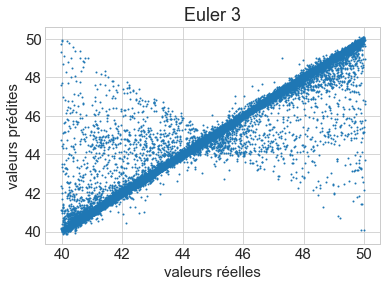

In [78]:
for i in range(3):
    axe = plt.axes()
    plt.rcParams.update({'font.size':15})
    plt.style.use('seaborn-whitegrid')
    plt.scatter(y_4[:, i], val_predictions4[:, i], s=1)
    plt.title('Euler ' + str(i+1))
    axe.set(xlabel="valeurs réelles", ylabel="valeurs prédites")
    plt.show()
# plt.scatter(X_test, y_test, label="Données d'évaluation", color="b")

on affiche le nombre d'erreurs que fait notre modèle sur ces nouvelles données

In [79]:
predictions2 = model.predict(X_2)
message2, erreur_y2, erreur_x2, nb_error_2 = pourcentage_erreur(predictions3, y_2, X_2)
print(message3)
predictions4 = model.predict(X_4)
message4, erreur_y4, erreur_x4, nb_error_4 = pourcentage_erreur(predictions4, y_4, X_4)
print(message4)
predictions5 = model.predict(X_5)
message5, erreur_y5, erreur_x5, nb_error_5 = pourcentage_erreur(predictions5, y_5, X_5)
print(message5)

KeyboardInterrupt: 

In [ ]:
erreur_y2.shape

In [ ]:
erreur_x2.shape

On récupère les valeurs d'entrée et de sortie X ey y des trois jeux de données pour lesquelles le modèle prédit mal dans trois matrices et on les mélanges à 50% d'autres valeurs aléatoires pour avoir trois jeux de données composés de 50% d'erreurs et 50% d'autres valeurs aléatoires.

In [ ]:
matrix_y3 = np.ones((1, 3), dtype=float)
matrix_x3 = np.ones((1, 22), dtype=float)

for i in range(nb_error_3):
    nb = np.random.randint(0, X_3.shape[0] - 1)
    matrix_y3 = np.append(matrix_y3, [y_3[nb]], axis=0)
    matrix_x3 = np.append(matrix_x3, [X_3[nb]], axis=0)
    
matrix_y3 = np.delete(matrix_y3, 0, axis=0)
matrix_x3 = np.delete(matrix_x3, 0, axis=0)
# ==============================================
matrix_y4 = np.ones((1, 3), dtype=float)
matrix_x4 = np.ones((1, 22), dtype=float)

for i in range(nb_error_4):
    nb = np.random.randint(0, X_4.shape[0] - 1)
    matrix_y4 = np.append(matrix_y4, [y_4[nb]], axis=0)
    matrix_x4 = np.append(matrix_x4, [X_4[nb]], axis=0)
    
matrix_y4 = np.delete(matrix_y4, 0, axis=0)
matrix_x4 = np.delete(matrix_x4, 0, axis=0)
#=============================================
matrix_y5 = np.ones((1, 3), dtype=float)
matrix_x5 = np.ones((1, 22), dtype=float)

for i in range(nb_error_5):
    nb = np.random.randint(0, X_5.shape[0] - 1)
    matrix_y5 = np.append(matrix_y5, [y_5[nb]], axis=0)
    matrix_x5 = np.append(matrix_x5, [X_5[nb]], axis=0)
    
matrix_y5 = np.delete(matrix_y5, 0, axis=0)
matrix_x5 = np.delete(matrix_x5, 0, axis=0)

In [ ]:
matrix_x3.shape

In [ ]:
matrix_y3.shape

On regroupe les trois matrices précédentes dans une seule

In [ ]:
new_X3 = np.concatenate((matrix_x3, erreur_x3), axis=0)
new_Y3 = np.concatenate((matrix_y3, erreur_y3), axis=0)

new_X4 = np.concatenate((matrix_x4, erreur_x4), axis=0)
new_Y4 = np.concatenate((matrix_y4, erreur_y4), axis=0)

new_X5 = np.concatenate((matrix_x5, erreur_x5), axis=0)
new_Y5 = np.concatenate((matrix_y5, erreur_y5), axis=0)

new_X_ = np.concatenate((new_X3, new_X4), axis=0)
new_Y_ = np.concatenate((new_Y3, new_Y4), axis=0)

new_X = np.concatenate((new_X_, new_X5), axis=0)
new_Y = np.concatenate((new_Y_, new_Y5), axis=0)

In [ ]:
new_X.shape

In [ ]:
new_Y.shape

on sépare nos nouvelles données composé de 50% d'erreurs et 50% aléatoire en 80 % de données d'entraîenement et 20 % données de test

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(new_X, new_Y, test_size=0.2, random_state=1)

on crée un nouveau modèle avec le meme nombre de couches que le précédent

on donne au modèle nos nouvelles données composées de 50% d'erreurs et 50% d'aléatoires
on peut jouer avec le batch_size , le nombre d'epochs etc
augmenter le batch_size et réentrâiner plusieurs fois

In [ ]:
model.compile(
    optimizer="adam", 
    loss="mae", # mse
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

history = model.fit(
    x=X_train2, 
    y=y_train2, 
    epochs=10000,
    batch_size=32,
    validation_data=(X_test2, y_test2)
)

ou bien on utilise le modèle précédent ou un autres

on fait prédire à notre nouveau modèle toutes les données des trois fichiers (les modèles ne les ont jamais vu)

In [ ]:
pred3 = model.predict(X_3)
pred4 = model.predict(X_4)
pred5 = model.predict(X_5)

on fait aussi prédire nos données composés de 50% d'erreurs et 50% aléatoires

In [ ]:
pred = model.predict(new_X)

on affiche trois graphique pour visualiser la qulaité du modèle sur les données 50 50

In [ ]:
for i in range(3):
    axe = plt.axes()
    plt.rcParams.update({'font.size':15})
    plt.style.use('seaborn-whitegrid')
    plt.scatter(new_Y[:, i], pred[:, i], s=1)
    plt.title('Euler ' + str(i+1))
    axe.set(xlabel="valeurs réelles", ylabel="valeurs prédites")
    plt.show()

on affiche aussi trois graphiques pour visulaiser les performances du modèles sur toutes les données d'un des fichiers importés

In [ ]:
for i in range(3):
    axe = plt.axes()
    plt.rcParams.update({'font.size':15})
    plt.style.use('seaborn-whitegrid')
    plt.scatter(y_4[:, i], pred4[:, i], s=1)
    plt.title('Euler ' + str(i+1))
    axe.set(xlabel="valeurs réelles", ylabel="valeurs prédites")
    plt.show()

on calcule le nombre d'erreurs de 1 degré ou plus sur les données 50 50

In [ ]:
msg, erry, errx, err = pourcentage_erreur(pred, new_Y, new_X)
print(msg)

on calcule le nombre d'erreurs de 1 degré ou plus sur les trois fichiers de données

In [ ]:
message3, erreur_y3, erreur_x3, err3 = pourcentage_erreur(pred3, y_3, X_3)
print(message3)

message4, erreur_y4, erreur_x4, err4 = pourcentage_erreur(pred4, y_4, X_4)
print(message4)

message5, erreur_y5, erreur_x5, err5 = pourcentage_erreur(pred5, y_5, X_5)
print(message5)

On va réentraîner notre modèle_erreur avec les les données d'un des fichiers après qu'il s'est entraîner avec des données 50% erreur 50% aléaatoire et qu'il a a baissé à 10% d'erreurs sur les données 50 50

In [ ]:
model.compile(
    optimizer='adam',    # opti,
    loss="mae",    # "mae", # mse
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

In [ ]:
history = model.fit(
    x=X_train, 
    y=y_train,
    batch_size = 10000,
    epochs=2000,
    validation_data=(X_test, y_test)
)

On test mainetanant notre modèle sur les données des trois fichiers

In [ ]:
predictions3 = model.predict(X_3)
message3, erreur_y3, erreur_x3, nb_error_3 = pourcentage_erreur(predictions3, y_3, X_3)
print(message3)
predictions4 = model.predict(X_4)
message4, erreur_y4, erreur_x4, nb_error_4 = pourcentage_erreur(predictions4, y_4, X_4)
print(message4)
predictions5 = model.predict(X_5)
message5, erreur_y5, erreur_x5, nb_error_5 = pourcentage_erreur(predictions5, y_5, X_5)
print(message5)